In [1]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn.model_selection
import random
from tensorflow.keras import layers, Model

In [3]:
# to download from
file_id = "1el92N8lBia2a5RFK0leeFQFRyhsEXaZx"
!gdown --id {file_id} -O rare_species.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx
From (redirected): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx&confirm=t&uuid=fb5402ac-f409-43e5-99c0-b75f4baac492
To: /content/rare_species.zip
100% 4.26G/4.26G [00:41<00:00, 103MB/s]


In [4]:
# verify file size
!ls -lh rare_species.zip

-rw-r--r-- 1 root root 4.0G Apr 11 12:01 rare_species.zip


In [5]:
# directory creation for excation
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

Created directory: /content/rare_species


In [6]:
# extraction
print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Extracting zip 
Extraction complete


In [7]:
# list fo contents for double-check
!ls -la {extract_path}

total 2924
drwxr-xr-x 204 root root   12288 Apr 17 12:14 .
drwxr-xr-x   1 root root    4096 Apr 17 12:13 ..
drwxr-xr-x   2 root root   12288 Apr 17 12:13 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Apr 17 12:14 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Apr 17 12:14 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Apr 17 12:13 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Apr 17 12:13 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   20480 Apr 17 12:13 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Apr 17 12:13 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Apr 17 12:13 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Apr 17 12:13 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Apr 17 12:14 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Apr 17 12:13 arthropoda_papilionidae
drwxr-xr-x   2 root root    4096 Apr 17 12:14 arthropoda_pisauridae
drwxr-xr-x   2 root root    4096 Apr 17 12:14 arthropoda_platystictidae


In [8]:
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")

Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

In [9]:
# Dropper les colonnes inutiles
columns_to_keep = ['file_path', 'family', 'phylum']  # Garder seulement ce qui est nécessaire
metadata = metadata[columns_to_keep]
print('Colonnes restantes:', metadata.columns.tolist())

Colonnes restantes: ['file_path', 'family', 'phylum']


In [10]:
metadata.head()

,file_path,family,phylum
0,mollusca_unionidae/12853737_449393_eol-full-si...,unionidae,mollusca
1,chordata_geoemydidae/20969394_793083_eol-full-...,geoemydidae,chordata
2,chordata_cryptobranchidae/28895411_319982_eol-...,cryptobranchidae,chordata
3,chordata_turdidae/29658536_45510188_eol-full-s...,turdidae,chordata
4,chordata_indriidae/21252576_7250886_eol-full-s...,indriidae,chordata


# EDA

# Preprocessing of Yasmine


Visualisation des images avant/après prétraitement et augmentations


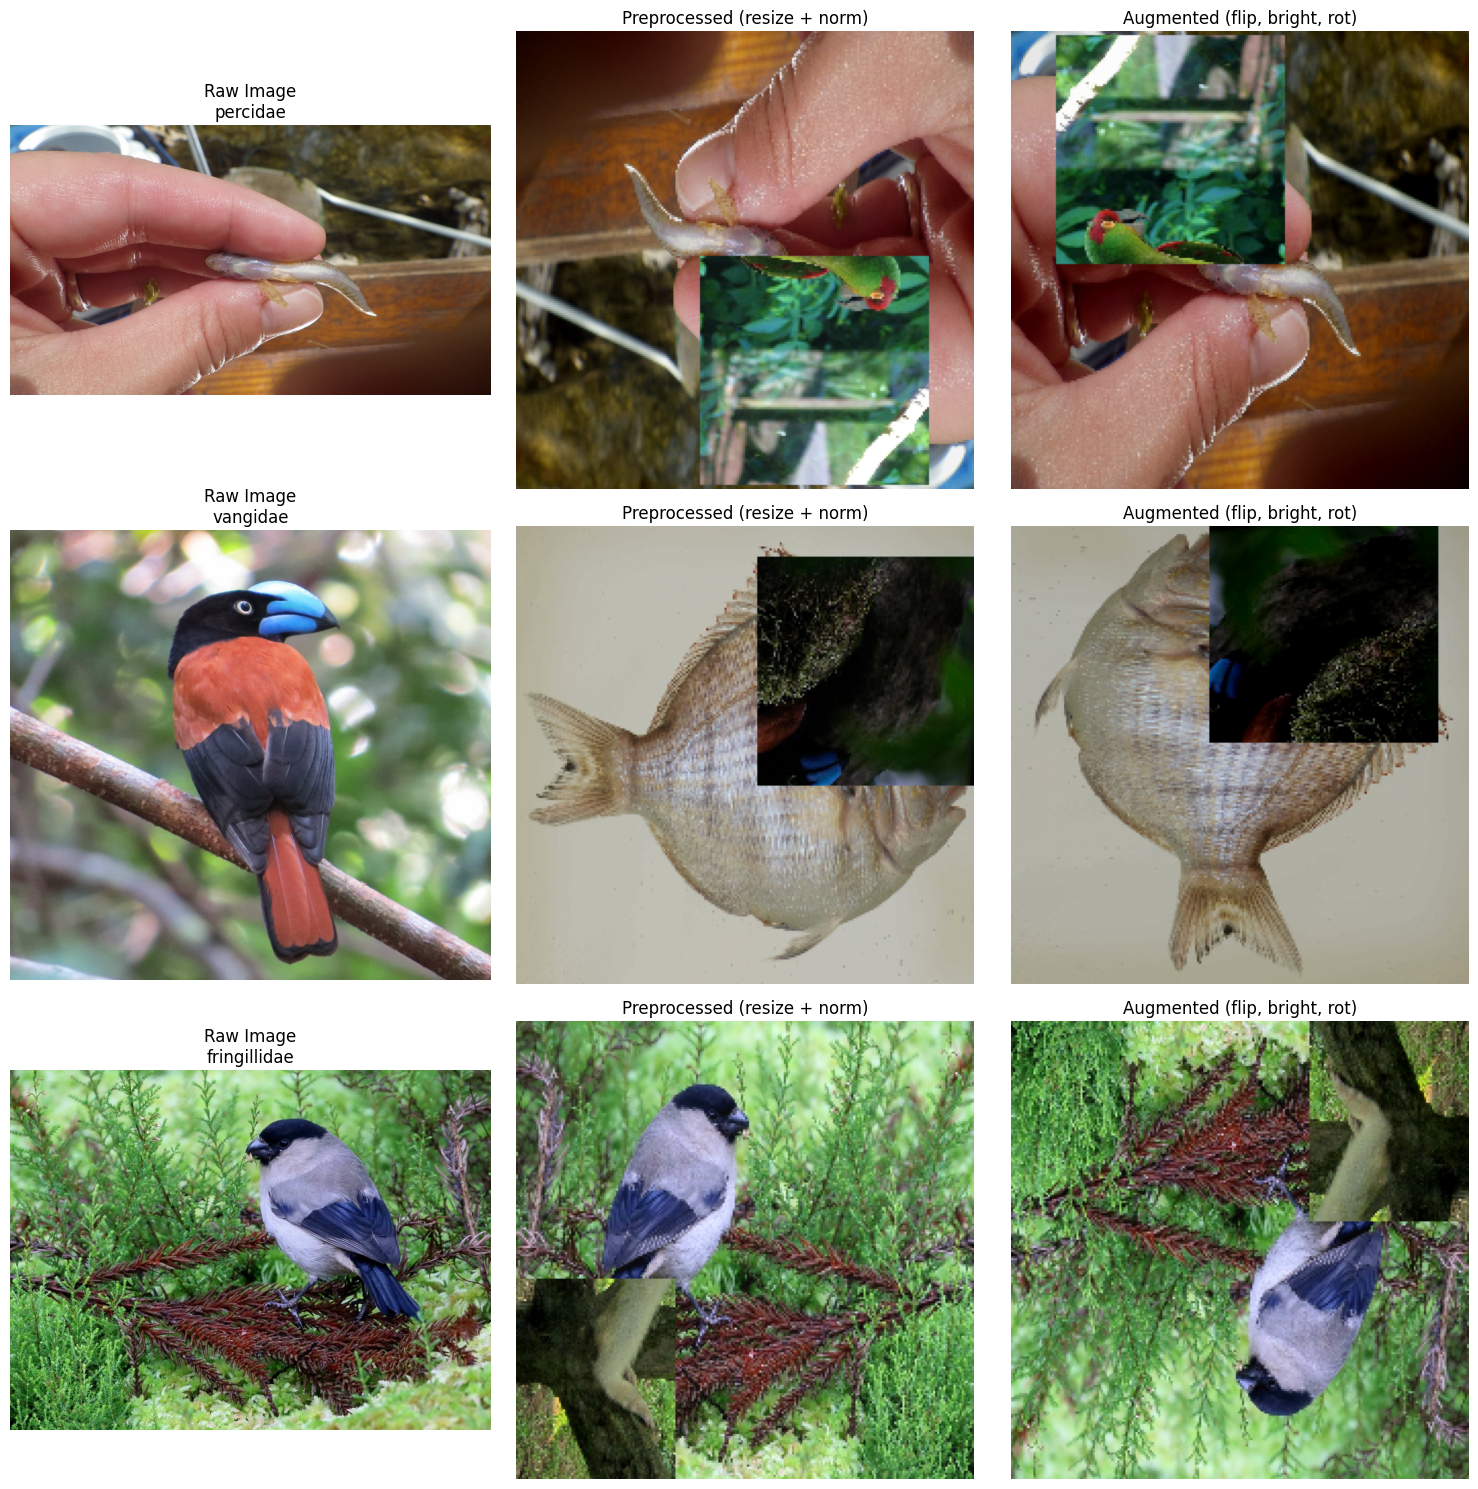

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Configuration
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Normalisation ImageNet
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Métrique personnalisée pour Macro F1
class MacroF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)  # (batch_size,)
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)  # (batch_size,)

        classes = tf.range(self.num_classes)  # (num_classes,)
        true_mask = tf.equal(tf.expand_dims(y_true, -1), classes)  # (batch_size, num_classes)
        pred_mask = tf.equal(tf.expand_dims(y_pred, -1), classes)  # (batch_size, num_classes)

        tp = tf.reduce_sum(tf.cast(tf.logical_and(true_mask, pred_mask), tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_mask), pred_mask), tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(tf.logical_and(true_mask, tf.logical_not(pred_mask)), tf.float32), axis=0)

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-10)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        return tf.reduce_mean(f1)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

# Fonctions globales pour le pipeline
@tf.function
def preprocess(file_path, family, phylum, family_lookup, phylum_lookup):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    img = tf.ensure_shape(img, [224, 224, 3])
    phylum_idx = phylum_lookup(phylum)
    family_idx = family_lookup(family)
    return (img, phylum_idx), family_idx

@tf.function
def augment(image_phylum, label):
    image, phylum = image_phylum
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    image = tf.ensure_shape(image, [224, 224, 3])
    return (image, phylum), label

@tf.function
def cutmix(image_phylum, label):
    image, phylum = image_phylum
    label = tf.ensure_shape(label, [None])

    batch_size = tf.shape(image)[0]
    lam = tf.random.uniform([], minval=0.5, maxval=1.0, dtype=tf.float32)

    idx = tf.random.shuffle(tf.range(batch_size))
    img_a = image
    img_b = tf.gather(image, idx)
    lbl_a = label
    lbl_b = tf.gather(label, idx)

    height, width = IMG_SIZE[0], IMG_SIZE[1]
    y = tf.random.uniform([], 0, height, dtype=tf.int32)
    x = tf.random.uniform([], 0, width, dtype=tf.int32)
    y1 = tf.clip_by_value(y - height // 4, 0, height)
    y2 = tf.clip_by_value(y + height // 4, 0, height)
    x1 = tf.clip_by_value(x - width // 4, 0, width)
    x2 = tf.clip_by_value(x + width // 4, 0, width)

    mask = tf.ones_like(img_a, dtype=tf.float32)
    y_indices = tf.tile(tf.expand_dims(tf.range(height), 1), [1, width])
    x_indices = tf.tile(tf.expand_dims(tf.range(width), 0), [height, 1])
    mask_patch = tf.logical_and(
        tf.logical_and(y_indices >= y1, y_indices < y2),
        tf.logical_and(x_indices >= x1, x_indices < x2)
    )
    mask_patch = tf.expand_dims(mask_patch, 0)
    mask_patch = tf.expand_dims(mask_patch, -1)
    mask_patch = tf.tile(mask_patch, [batch_size, 1, 1, 3])
    mask = tf.where(mask_patch, tf.zeros_like(mask), mask)
    mask = tf.cast(mask, tf.float32)

    image = img_a * mask + img_b * (1. - mask)
    image = tf.ensure_shape(image, [None, 224, 224, 3])

    label = tf.where(tf.random.uniform([]) < lam, lbl_a, lbl_b)

    return (image, phylum), label

# 1. Préparation des données
def prepare_datasets(data_path):
    if not os.path.exists(data_path + '/metadata.csv'):
        raise FileNotFoundError(f"Metadata file not found at {data_path}/metadata.csv")

    metadata = pd.read_csv(data_path + '/metadata.csv')
    metadata['file_exists'] = metadata['file_path'].apply(lambda x: os.path.exists(data_path + '/' + x))
    metadata = metadata[metadata['file_exists']]

    if len(metadata) == 0:
        raise ValueError("No valid images found in the dataset")

    metadata = metadata[['file_path', 'family', 'phylum']]

    file_paths = [os.path.join(data_path, fp) for fp in metadata['file_path'].values]
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    if len(file_paths) < 10:
        print(f"Warning: Small dataset size ({len(file_paths)} images). Consider adding more data.")

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2,
        stratify=family_labels,
        random_state=SEED
    )

    MAX_TRAIN = 500
    MAX_VAL = 100

    train_paths = train_paths[:MAX_TRAIN]
    val_paths = val_paths[:MAX_VAL]
    train_families = train_families[:MAX_TRAIN]
    val_families = val_families[:MAX_VAL]
    train_phyla = train_phyla[:MAX_TRAIN]
    val_phyla = val_phyla[:MAX_VAL]

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(phylum_labels)

    train_classes = set(np.unique(train_families))
    val_classes = set(np.unique(val_families))
    missing_in_train = val_classes - train_classes
    if missing_in_train:
        print(f"Warning: {len(missing_in_train)} classes in val but not in train: {missing_in_train}")

    unique_classes, counts = np.unique(train_families, return_counts=True)
    class_weights = {family_lookup(cls).numpy(): 1.0 / count for cls, count in zip(unique_classes, counts)}
    total = sum(class_weights.values())
    class_weights = {k: v / total * len(class_weights) for k, v in class_weights.items()}

    train_family_indices = [family_lookup(f).numpy() for f in train_families]

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    train_ds = train_ds.shuffle(buffer_size=1000, seed=SEED)
    train_ds = train_ds.map(
        lambda x, y, z: preprocess(x, y, z, family_lookup, phylum_lookup),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)

    val_ds = val_ds.map(
        lambda x, y, z: preprocess(x, y, z, family_lookup, phylum_lookup),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, class_weights, train_paths, train_families, train_phyla, train_family_indices

# 2. Visualisation avant/après
def visualize_preprocessing(train_ds, train_paths, train_families, train_phyla, family_lookup, train_family_indices, num_examples=3):
    def denormalize(img):
        img = img * IMAGENET_STD + IMAGENET_MEAN
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img

    plt.figure(figsize=(15, num_examples * 5))

    for i, ((img, phylum), label) in enumerate(train_ds.take(num_examples)):
        label_scalar = label.numpy()[0]
        try:
            idx = train_family_indices.index(label_scalar)
            file_path = train_paths[idx]
        except ValueError:
            print(f"Warning: No matching file_path found for label {label_scalar}. Skipping.")
            continue

        raw_img = tf.io.read_file(file_path)
        raw_img = tf.image.decode_jpeg(raw_img, channels=3)
        raw_img = tf.cast(raw_img, tf.float32) / 255.0

        preprocessed_img = denormalize(img[0])

        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(raw_img)
        plt.title(f"Raw Image\n{family_lookup.get_vocabulary()[label_scalar]}")
        plt.axis('off')

        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(preprocessed_img)
        plt.title("Preprocessed (resize + norm)")
        plt.axis('off')

        aug_img, _ = augment((img[0], phylum[0]), label[0])
        aug_img = denormalize(aug_img[0])
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(aug_img)
        plt.title("Augmented (flip, bright, rot)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Créer les datasets
try:
    train_ds, val_ds, family_lookup, phylum_lookup, class_weights, train_paths, train_families, train_phyla, train_family_indices = prepare_datasets(DATA_PATH)
    NUM_FAMILIES = len(family_lookup.get_vocabulary())
    NUM_PHYLA = len(phylum_lookup.get_vocabulary())
except Exception as e:
    print(f"Error in prepare_datasets: {e}")
    raise

# 4. Visualiser
print("Visualisation des images avant/après prétraitement et augmentations")
visualize_preprocessing(train_ds, train_paths, train_families, train_phyla, family_lookup, train_family_indices)

# 5. Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=NUM_FAMILIES)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        loss = alpha * tf.pow(1.0 - pt, gamma) * ce
        return tf.reduce_mean(loss)
    return focal

# ACC of 12%

In [15]:
# Função para criar o modelo com VGG16
def build_vgg16_model(num_phyla, num_families):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # congelar os pesos da VGG16

    image_input = tf.keras.Input(shape=(224, 224, 3), name='image')
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name='phylum')

    x = base_model(image_input, training=False)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output = tf.keras.layers.Dense(num_families, activation='softmax', name='family')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name="VGG16_Model")

# Construir o modelo
vgg_model = build_vgg16_model(num_phyla=NUM_PHYLA, num_families=NUM_FAMILIES)

# Compilar
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=focal_loss(),
    metrics=['accuracy', MacroF1(num_classes=NUM_FAMILIES)],
    jit_compile=False
)

# Treinar
vgg_history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    steps_per_epoch=max(1, len(train_paths) // BATCH_SIZE),
    class_weight=class_weights,
    callbacks=callbacks
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 359s 12s/step - accuracy: 0.0138 - loss: 1.2783 - macro_f1: 0.0036 - val_accuracy: 0.0000e+00 - val_loss: 1.5010 - val_macro_f1: 0.0000e+00
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 377s 11s/step - accuracy: 0.0541 - loss: 0.9615 - macro_f1: 0.0081 - val_accuracy: 0.0000e+00 - val_loss: 1.4221 - val_macro_f1: 0.0000e+00
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 350s 11s/step - accuracy: 0.0945 - loss: 0.8525 - macro_f1: 0.0204 - val_accuracy: 0.0208 - val_loss: 1.3761 - val_macro_f1: 0.0011
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 381s 11s/step - accuracy: 0.0673 - loss: 0.8317 - macro_f1: 0.0144 - val_accuracy: 0.0521 - val_loss: 1.3613 - val_macro_f1: 0.0060
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.0676 - loss: 0.7933 - macro_f1: 0.0156 - val_accuracy: 0.0312 - val_loss: 1.3235 - val_macro_f1: 0.0014
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 385s 11s/step - accuracy: 0.1255 - loss: 0.76

# different approach with 4 different models and a small part of the data set: MAX_TRAIN = 500, MAX_VAL = 100


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


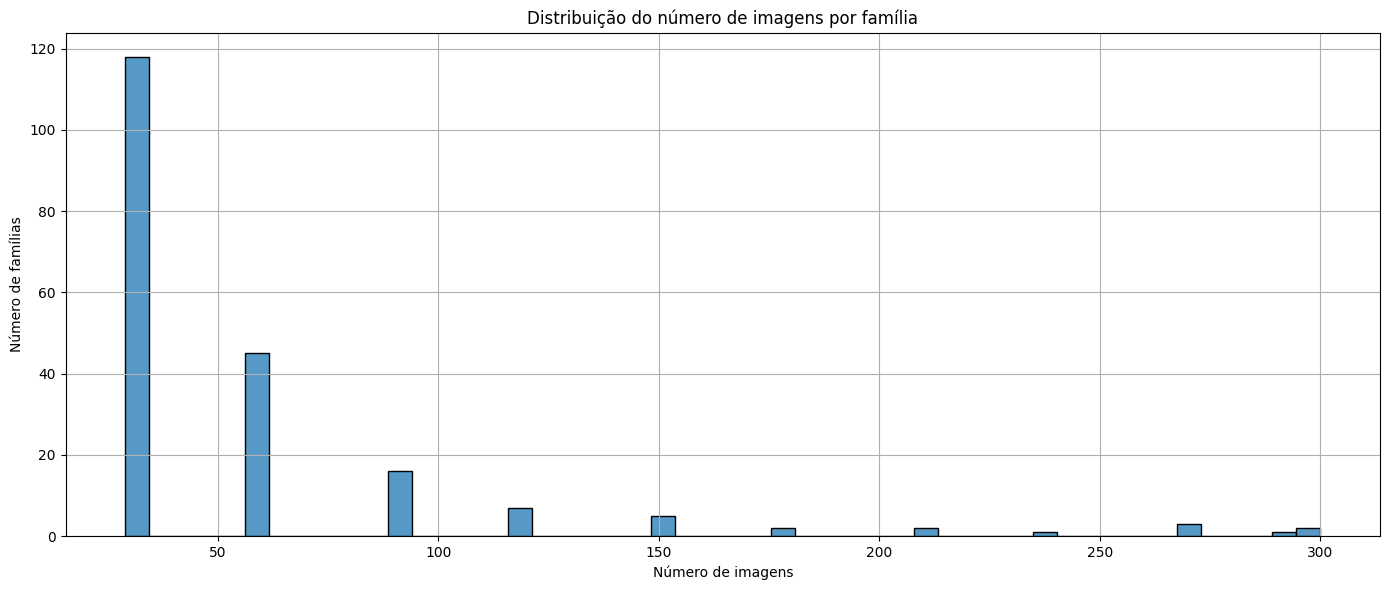

Famílias com menos de 10 imagens:
Series([], Name: count, dtype: int64)
✅ Dados carregados e prontos
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 386s 12s/step - accuracy: 0.0166 - loss: 5.2147 - val_accuracy: 0.0600 - val_loss: 5.0790
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 383s 12s/step - accuracy: 0.0345 - loss: 4.9831 - val_accuracy: 0.0200 - val_loss: 5.0162
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 444s 12s/step - accuracy: 0.0448 - loss: 4.8421 - val_accuracy: 0.0500 - val_loss: 4.9228
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 417s 11s/step - accuracy: 0.0969 - loss: 4.6781 - val_accuracy: 0.0300 - val_loss: 4.8800
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 387s 12s/step - accuracy: 0.0858 - loss: 4.5560 - val_accuracy: 0.0600 - val_loss: 4.7887
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 431s 12s/step - accuracy: 0.1220 - loss: 4.4270 - val_accuracy: 0.0700 - val_loss: 4.7266
Epoch 7/20
32/32 ━━━━━━━━━━━━

In [ ]:
# Improved Preprocessing + Model Analysis (versão com base no teu setup)

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

# Configurações gerais
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Normalização baseada no ImageNet
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# 1. FILTRAR IMAGENS COM QUALIDADE BAIXA

def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]

# 2. ANALISAR FAMILIAS

def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

# 3. PREPARAR OS DADOS (com classes garantidas em treino/validação)

def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    MAX_TRAIN = 500
    MAX_VAL = 100

    train_paths = train_paths[:MAX_TRAIN]
    val_paths = val_paths[:MAX_VAL]
    train_families = train_families[:MAX_TRAIN]
    val_families = val_families[:MAX_VAL]
    train_phyla = train_phyla[:MAX_TRAIN]
    val_phyla = val_phyla[:MAX_VAL]

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        phylum_idx = phylum_lookup(phylum)
        family_idx = family_lookup(family)
        return (img, phylum_idx), family_idx

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

# CHAMAR FLUXO COMPLETO
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)

NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("✅ Dados carregados e prontos")

# ---------------------------------------------
# ✅ BLOCO 6: DEFINIÇÃO DE MODELOS PRONTOS
# ---------------------------------------------

def build_pretrained_model(base_model, name, num_phyla, num_families):
    base_model.trainable = False
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

# Exemplos de uso:
model_vgg16 = build_pretrained_model(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary())
)

model_resnet = build_pretrained_model(
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "ResNet50_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

model_efficient = build_pretrained_model(
    tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "EfficientNetB0_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

# ---------------------------------------------
# ✅ BLOCO 7: MODELO PERSONALIZADO
# ---------------------------------------------
def build_custom_cnn(num_phyla, num_families):
    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

# ---------------------------------------------
# ✅ BLOCO 8: INSTRUÇÕES PARA TREINO
# ---------------------------------------------

# Podes agora compilar e treinar qualquer um dos modelos assim:
model = model_vgg16  # ou model_resnet, model_efficient, build_custom_cnn(...)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()
